# Analysis 3a: Real World Datasets Audio Data

Imports, Functs and Paths

In [1]:
from scipy.stats import pointbiserialr
from myst_nb import glue
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot styles
from sciplotlib import style
from leakconfound.analyses.load import gather_data, data_to_long, models_renamer
from leakconfound.plotting import custom_bar_rope_plot
from leakconfound.analyses.utils import save_paper_val

import matplotlib as mpl

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_save_paper = "./paper_val/"
results_base = "../../results/"
base_dir = "../../"
audio_data_non_TaCo_folder = f"{results_base}basic_non_TaCo/realistic_non_TaCo/"
audio_data_TaCo_folder = f"{results_base}basic_TaCo/realistic/"
audio_data_robust_non_TaCo_folder = (
    f"{results_base}robust_cr_non_TaCo/realistic_non_TaCo/"
)
audio_data_shuffled_TaCo_folder = f"{results_base}shuffled_features_TaCo/realistic/"
audio_data_shuffled_non_TaCo_folder = (
    f"{results_base}" "shuffled_features_non_TaCo/realistic_non_TaCo/"
)

colors = [
    "#E64B35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2FF",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]


def mm_to_inch(val_in_inch):
    mm = 0.1 / 2.54
    return val_in_inch * mm


mpl.style.use(style.get_style("nature-reviews"))
mpl.rc("xtick", labelsize=11)
mpl.rc("ytick", labelsize=11)
mpl.rc("axes", labelsize=12, titlesize=12)
mpl.rc("figure", dpi=300)
mpl.rc("figure.subplot", wspace=mm_to_inch(8), hspace=0.7)
mpl.rc("lines", linewidth=1, markersize=2)

fig = plt.figure(
    figsize=[mm_to_inch(183), mm_to_inch(140)],
)


<Figure size 2161.42x1653.54 with 0 Axes>

In [2]:

def correct_fold_repeat(df):
    df.repeat = df.fold // 5
    df.fold = df.fold % 5
    return df


def convert_hat_scores(df):
    _df = df.copy()
    return (
        _df.assign(is_X_hat=lambda df: df.score_name.str.contains("X_hat"))
        .assign(
            confound=lambda df: df.apply(
                lambda row: "X hat" if row["is_X_hat"] else row["confound"], axis=1
            )
        )
        .assign(score_name=lambda df: df.score_name.str.replace("X_hat_", ""))
    )


def correct_columns(df):
    return correct_fold_repeat(convert_hat_scores(df))


Some info on the data:

In [3]:
data = pd.read_csv("../../data/realistic/audio_data/audio_data.csv")
bdi_median = data.BDI__continuous_confound.median()
bdi = data.BDI__continuous_confound.apply(lambda x: x > bdi_median)
adhd = data.ATT_Task__binary_target

print(pd.crosstab(adhd, bdi))

corr, p = pointbiserialr(bdi, adhd)

save_paper_val(
    base_save_paper,
    "real_world",
    "relation_BDI_ADHD",
    "p_pointbiserial",
    p,
    precision=3,
)

save_paper_val(
    base_save_paper, "real_world", "relation_BDI_ADHD", "r_pointbiserial", corr
)
print(f"pointbiserialr, r={corr:.2},p={p:.2}")

BDI__continuous_confound  False  True 
ATT_Task__binary_target               
0.0                          55      8
1.0                          17     46
pointbiserialr, r=0.61,p=3.7e-14


## Performance TaCo with Original Data

In [4]:
use_models = ["Linear/Logistic", "Decision Tree", "Random Forest"]
arguments_TaCo = ["data", "model_name", "is_deconfounded", "random_seed"]

score_names = [
    "test_roc_auc",
    "test_X_hat_roc_auc",
]
df_long_TaCo = (
    gather_data(audio_data_TaCo_folder, arguments_TaCo)
    .assign(model_name=lambda df: df.model_name.map(models_renamer))
    .query('(data.str.startswith("audio"))')
    .pipe(data_to_long, analysis_arguments=arguments_TaCo, score_names=score_names)
    .pipe(correct_columns)
)
Mrf_rem = (
    df_long_TaCo.query('(confound == "removed") & (model_name=="Random Forest")')
    .groupby("repeat")
    .mean()
    .score
)
Mrf_no_rem = (
    df_long_TaCo.query('(confound == "not removed") & (model_name=="Random Forest")')
    .groupby("repeat")
    .mean()
    .score
)
print(
    f"Performance no removal using RF M={Mrf_no_rem.mean():.2}, sd={Mrf_no_rem.std():.2}"
)
print(
    f"Performance after TaCo removal using RF M={Mrf_rem.mean():.2}, sd={Mrf_rem.std():.2}"
)

save_paper_val(
    base_save_paper, "real_world", "raw", "mean_audio_TaCo.txt", Mrf_no_rem.mean()
)

save_paper_val(
    base_save_paper, "real_world", "raw", "std_audio_TaCo.txt", Mrf_no_rem.std()
)

save_paper_val(
    base_save_paper, "real_world", "removed", "mean_audio_TaCo.txt", Mrf_rem.mean()
)

save_paper_val(
    base_save_paper, "real_world", "removed", "std_audio_TaCo.txt", Mrf_rem.std()
)

Performance no removal using RF M=0.71, sd=0.017
Performance after TaCo removal using RF M=0.81, sd=0.017


## Performance TaCo with Shuffled Data

In [5]:
df_long_shuffled_TaCo = (
    gather_data(audio_data_shuffled_TaCo_folder, arguments_TaCo)
    .assign(model_name=lambda df: df.model_name.map(models_renamer))
    .query('(data.str.startswith("audio"))')
    .pipe(data_to_long, analysis_arguments=arguments_TaCo, score_names=score_names)
    .pipe(correct_columns)
)
Mrf_shuffled_rem = (
    df_long_shuffled_TaCo.query(
        '(confound == "removed") & (model_name=="Random Forest")'
    )
    .groupby("repeat")
    .mean()
    .score
)
Mrf_shuffled_no_rem = (
    df_long_shuffled_TaCo.query(
        '(confound == "not removed") & (model_name=="Random Forest")'
    )
    .groupby("repeat")
    .mean()
    .score
)
print("shuffled Results:")
print(
    f"Performance no removal using RF M={Mrf_shuffled_no_rem.mean():.2},"
    f" sd={Mrf_shuffled_no_rem.std():.2}"
)
print(
    f"Performance after TaCo removal using RF M={Mrf_shuffled_rem.mean():.2},"
    f" sd={Mrf_shuffled_rem.std():.2}"
)

save_paper_val(
    base_save_paper,
    "real_world",
    "raw",
    "mean_audio_TaCo_shuffled.txt",
    Mrf_shuffled_no_rem.mean(),
)

save_paper_val(
    base_save_paper,
    "real_world",
    "raw",
    "std_audio_TaCo_shuffled.txt",
    Mrf_shuffled_no_rem.std(),
)

save_paper_val(
    base_save_paper,
    "real_world",
    "removed",
    "mean_audio_TaCo_shuffled.txt",
    Mrf_shuffled_rem.mean(),
)

save_paper_val(
    base_save_paper,
    "real_world",
    "removed",
    "std_audio_TaCo_shuffled.txt",
    Mrf_shuffled_rem.std(),
)

shuffled Results:
Performance no removal using RF M=0.48, sd=0.04
Performance after TaCo removal using RF M=0.77, sd=0.02


In [6]:
arguments = ["data", "model_name", "is_deconfounded", "random_seed", "confounds_used"]
confounds_used_pattern = r"confounds=\[(.+?)\]"
df_long_non_TaCo = (
    gather_data(audio_data_non_TaCo_folder, arguments)
    .assign(
        model_name=lambda df: df.model_name.map(models_renamer),
    )
    .query('(data.str.startswith("audio"))')
    .pipe(data_to_long, analysis_arguments=arguments, score_names=score_names)
    .pipe(correct_columns)
)

df_long_shuffled_non_TaCo = (
    gather_data(audio_data_shuffled_non_TaCo_folder, arguments)
    .assign(
        model_name=lambda df: df.model_name.map(models_renamer),
    )
    .query('(data.str.startswith("audio"))')
    .pipe(data_to_long, analysis_arguments=arguments, score_names=score_names)
    .pipe(correct_columns)
)


## Performance for each Confound Separated

In [7]:
print("Performance using RF ")
print("_" * 40)
print()
for confounds_used in df_long_non_TaCo.confounds_used.unique():
    Mrf_rem = (
        df_long_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "removed")'
        )
        .groupby("repeat")
        .score.mean()
    )

    Mrf_no_rem = (
        df_long_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "not removed")'
        )
        .groupby("repeat")
        .score.mean()
    )

    Mrf_rem_Xhat = (
        df_long_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "X hat")'
        )
        .groupby("repeat")
        .score.mean()
    )

    Mrf_no_rem_Xhat = (
        df_long_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "X hat")'
        )
        .groupby("repeat")
        .score.mean()
    )

    Mrf_rem_shuff = (
        df_long_shuffled_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "removed")'
        )
        .groupby("repeat")
        .score.mean()
    )

    Mrf_no_rem_shuff = (
        df_long_shuffled_non_TaCo.query(
            "(confounds_used == @confounds_used) & "
            '(model_name == "Random Forest") &'
            '(confound == "not removed")'
        )
        .groupby("repeat")
        .score.mean()
    )
    print("Confound: ", confounds_used)
    print("Raw:")
    print(f"No removal M={Mrf_no_rem.mean():.2}, sd={Mrf_no_rem.std():.2}")
    print(f"After CR M={Mrf_rem.mean():.2}, sd={Mrf_rem.std():.2}")

    print("Xhat:")
    print(f"No removal M={Mrf_no_rem_Xhat.mean():.2}, sd={Mrf_no_rem_Xhat.std():.2}")
    print(f"After CR M={Mrf_rem_Xhat.mean():.2}, sd={Mrf_rem_Xhat.std():.2}")

    print("Shuffled:")

    print(f"No removal M={Mrf_no_rem_shuff.mean():.2}, sd={Mrf_no_rem_shuff.std():.2}")
    print(f"After CR M={Mrf_rem_shuff.mean():.2}, sd={Mrf_rem_shuff.std():.2}")

    print("_" * 40)
    print()

    save_paper_val(
        base_save_paper,
        "real_world",
        "raw",
        f"mean_audio_conf_{confounds_used}.txt",
        Mrf_no_rem.mean(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "raw",
        f"std_audio_conf_{confounds_used}.txt",
        Mrf_no_rem.std(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "removed",
        f"mean_audio_conf_{confounds_used}.txt",
        Mrf_rem.mean(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "removed",
        f"std_audio_conf_{confounds_used}.txt",
        Mrf_rem.std(),
    )

    # X hat

    save_paper_val(
        base_save_paper,
        "real_world",
        "Xhat",
        f"mean_audio_conf_{confounds_used}.txt",
        Mrf_no_rem_Xhat.mean(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "Xhat",
        f"std_audio_conf_{confounds_used}.txt",
        Mrf_no_rem_Xhat.std(),
    )

    # Shuffled
    save_paper_val(
        base_save_paper,
        "real_world",
        "raw",
        f"mean_audio_conf_{confounds_used}_shuffled.txt",
        Mrf_no_rem_shuff.mean(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "raw",
        f"std_audio_conf_{confounds_used}_shuffled.txt",
        Mrf_no_rem_shuff.std(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "removed",
        f"mean_audio_conf_{confounds_used}_shuffled.txt",
        Mrf_rem_shuff.mean(),
    )

    save_paper_val(
        base_save_paper,
        "real_world",
        "removed",
        f"std_audio_conf_{confounds_used}_shuffled.txt",
        Mrf_rem_shuff.std(),
    )

Performance using RF 
________________________________________

Confound:  Gender
Raw:
No removal M=0.74, sd=0.02
After CR M=0.7, sd=0.021
Xhat:
No removal M=0.64, sd=0.0014
After CR M=0.64, sd=0.0014
Shuffled:
No removal M=0.54, sd=0.039
After CR M=0.6, sd=0.032
________________________________________

Confound:  Gender_Education_Age_BDI
Raw:
No removal M=0.74, sd=0.02
After CR M=0.86, sd=0.016
Xhat:
No removal M=0.88, sd=0.016
After CR M=0.88, sd=0.016
Shuffled:
No removal M=0.54, sd=0.039
After CR M=0.85, sd=0.019
________________________________________

Confound:  Education
Raw:
No removal M=0.74, sd=0.02
After CR M=0.74, sd=0.026
Xhat:
No removal M=0.58, sd=0.031
After CR M=0.58, sd=0.031
Shuffled:
No removal M=0.54, sd=0.039
After CR M=0.55, sd=0.042
________________________________________

Confound:  Age
Raw:
No removal M=0.74, sd=0.02
After CR M=0.73, sd=0.022
Xhat:
No removal M=0.56, sd=0.029
After CR M=0.56, sd=0.029
Shuffled:
No removal M=0.54, sd=0.039
After CR M=0.57, s

Plotting Relation of Confounds used
to no removal v removal

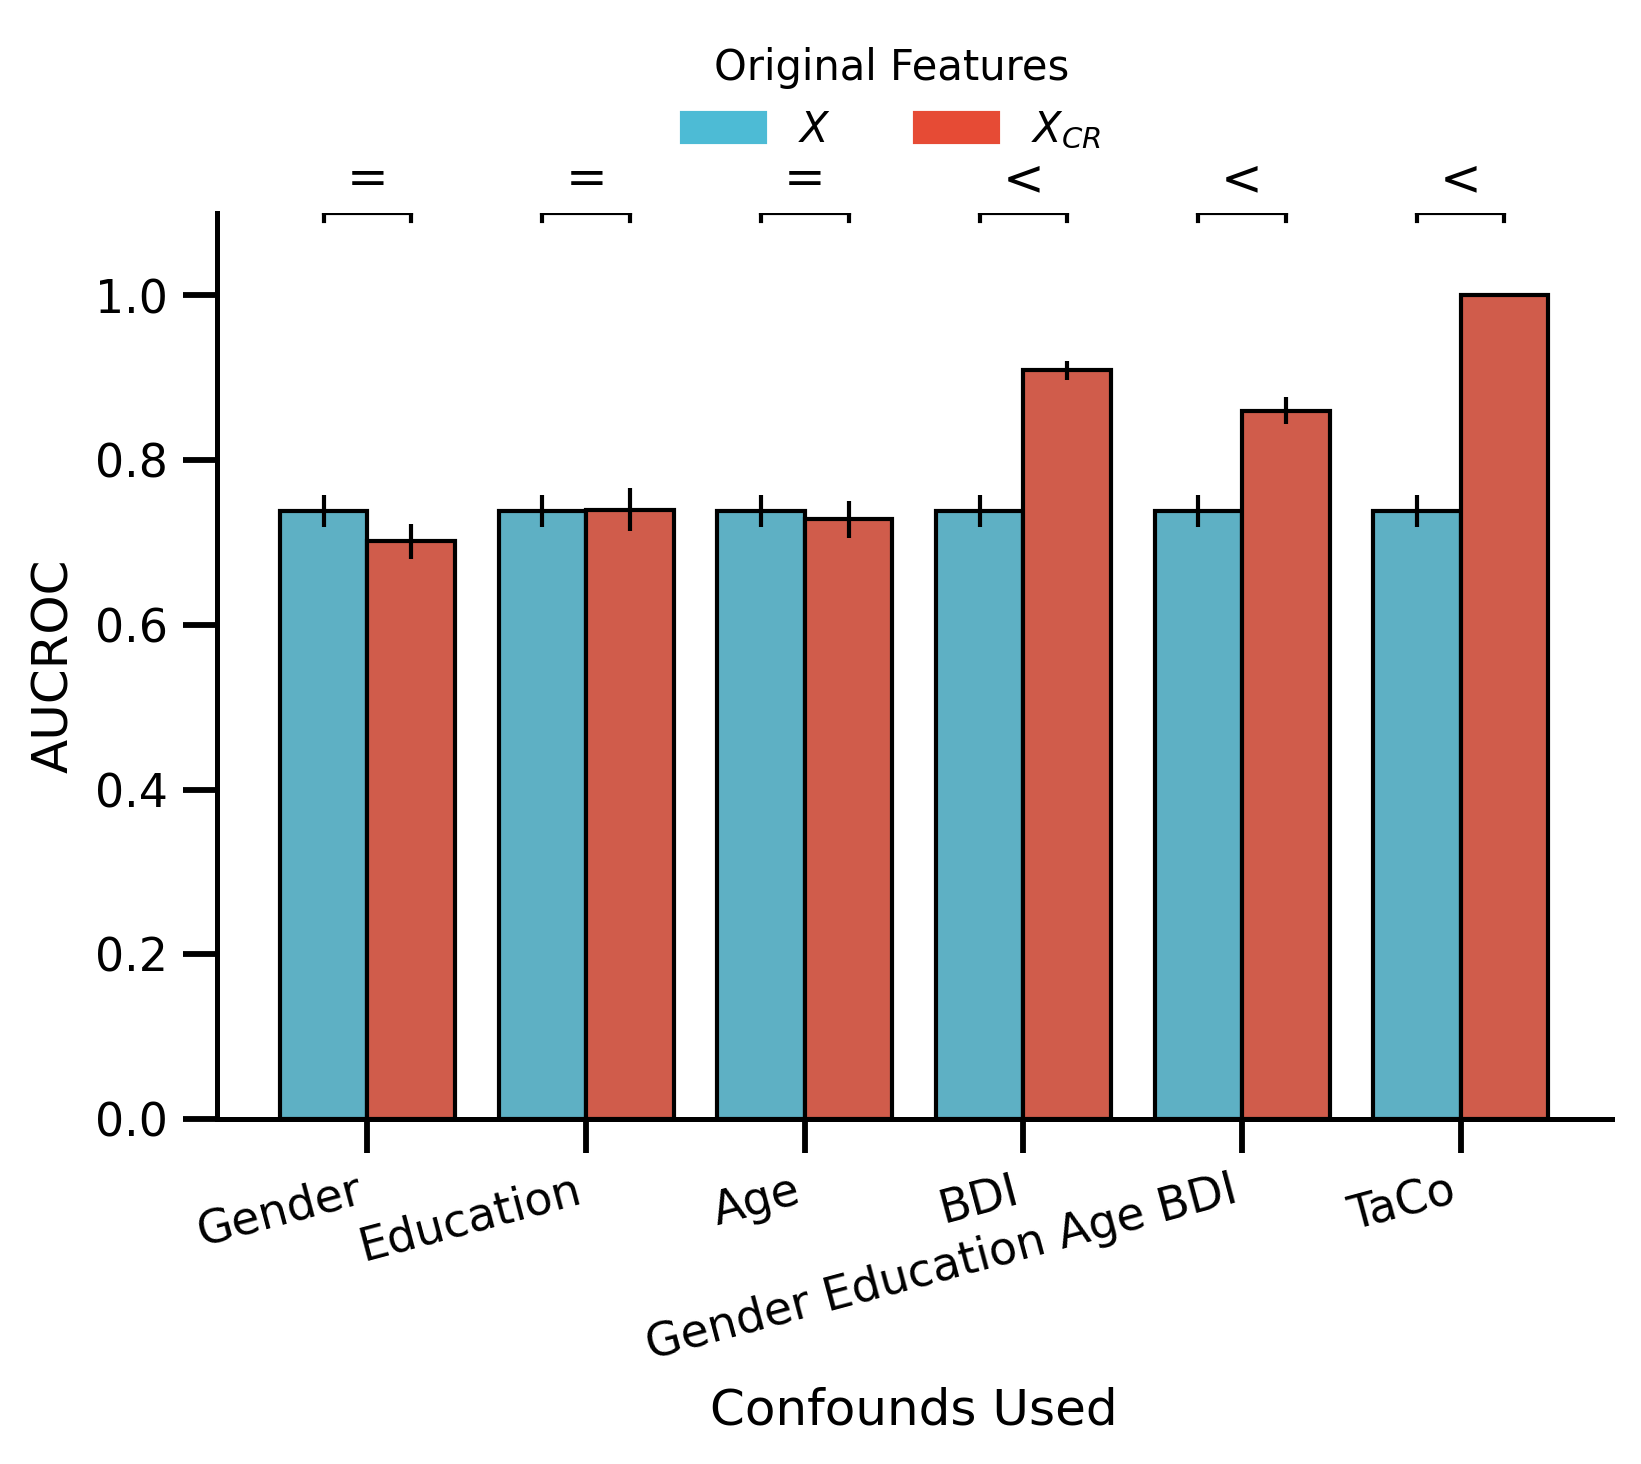

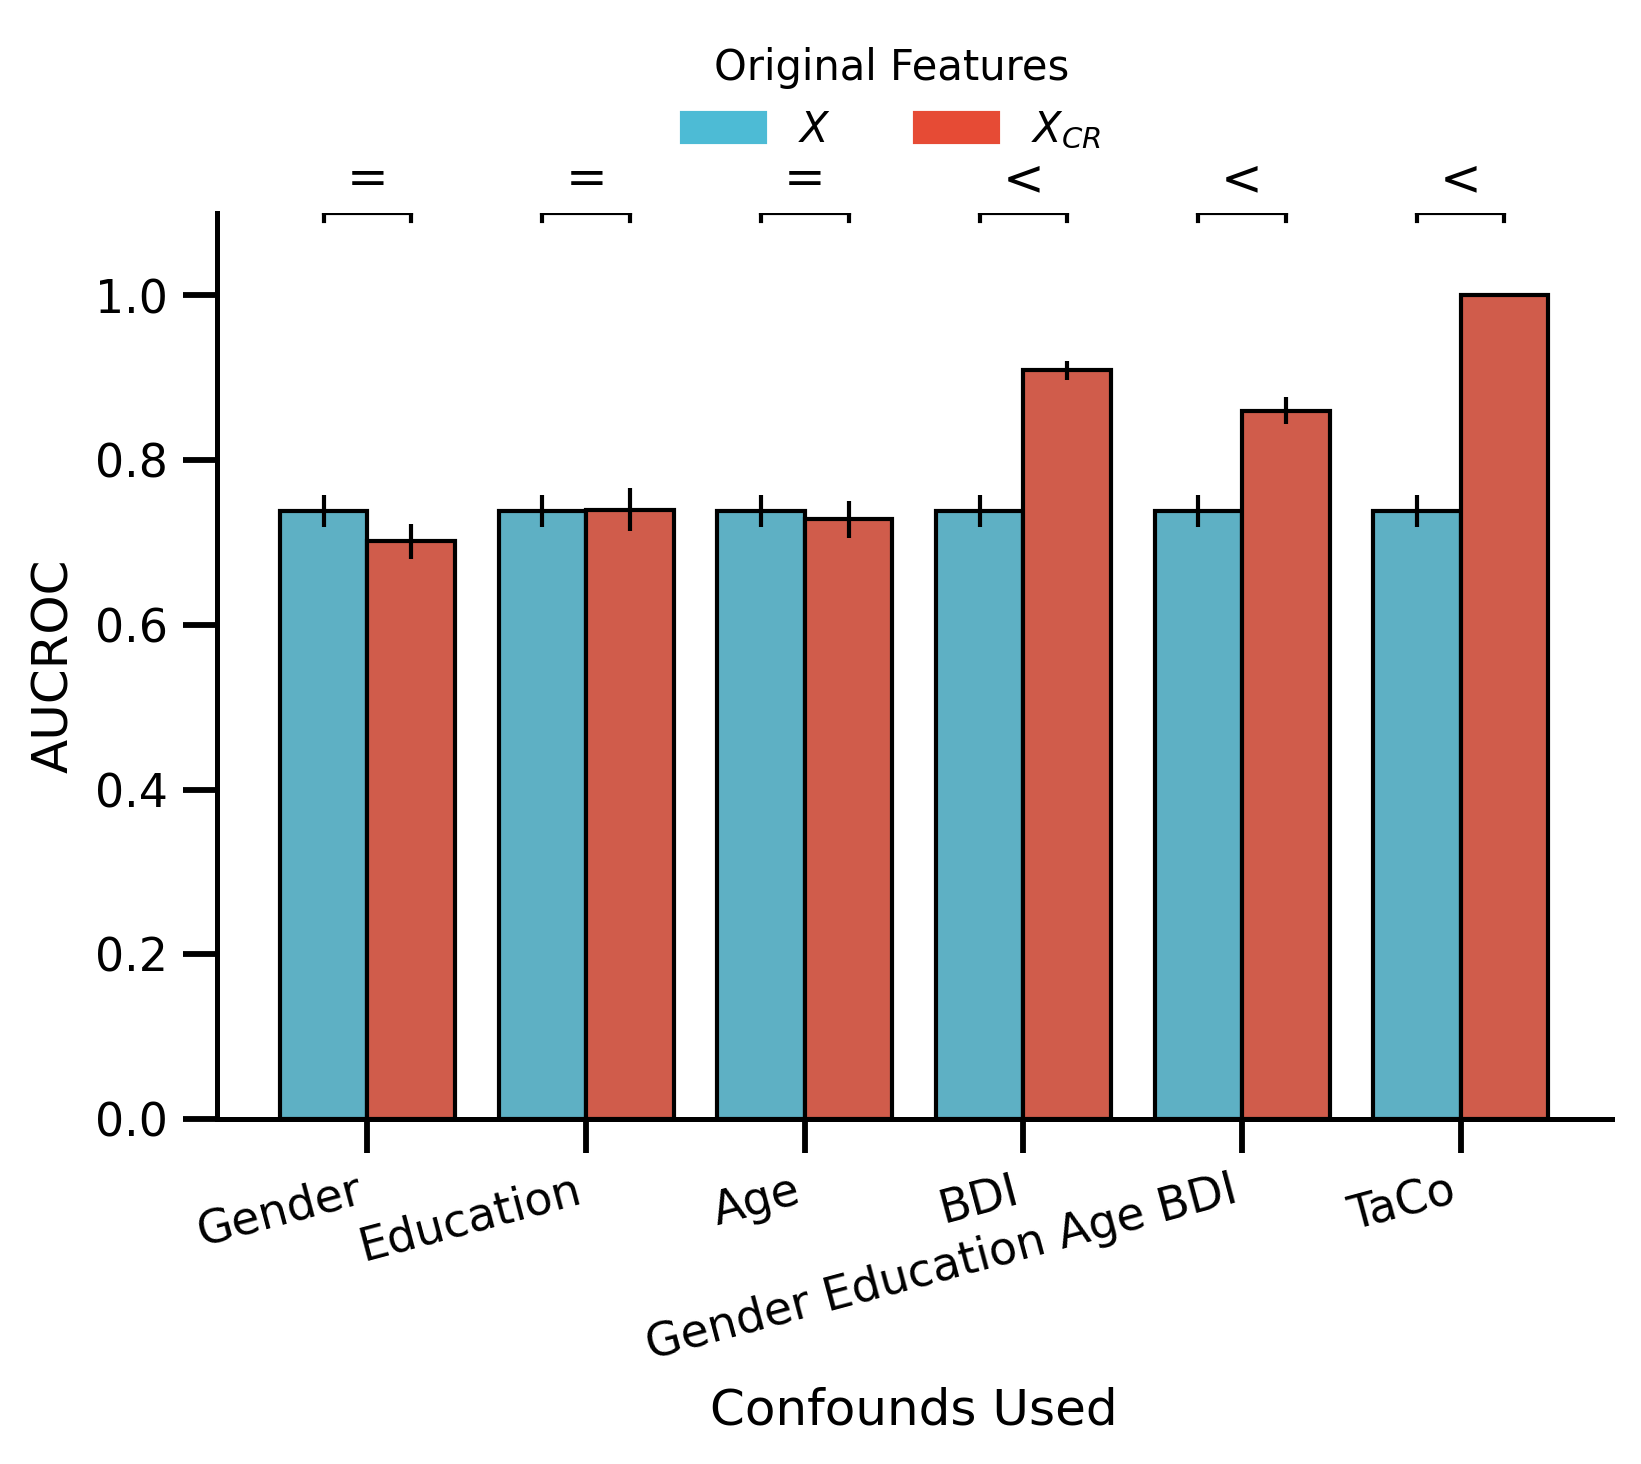

In [8]:
df_bar_plot = (
    pd.concat(
        [
            df_long_non_TaCo.copy().query("model_name == 'Random Forest'"),
            (
                df_long_TaCo.assign(confounds_used="TaCo")
                .query("model_name == 'Random Forest'")
                .query("data == 'audio_data'")
                .reset_index(drop=True)
            ),
        ]
    )
    .dropna()
    .reset_index(drop=True)
)


df_bar_plot = df_bar_plot.query("confound in ['not removed', 'removed']")
fig, ax = plt.subplots()
custom_bar_rope_plot(
    x="confounds_used",
    y="score",
    hue="confound",
    ax=ax,
    hue_order=["not removed", "removed"],
    comparisons=(("not removed", "removed"),),
    comparisons_sing_y=(1.1,),
    cv_repeats="repeat",
    data=df_bar_plot,
    rope=0.05,
    order=["Gender", "Education", "Age", "BDI", "Gender_Education_Age_BDI", "TaCo"],
    palette=sns.color_palette([blue, red]),
    show_legend=False,
)
ax.set_xticklabels(
    [i.get_text().replace("_", " ") for i in ax.get_xticklabels()],
    rotation=15,
    ha="right",
)
ax.set_ylim(0, 1.1)
ax.set_ylabel("AUCROC")
ax.set_xlabel("Confounds Used")

handles = [
    mpl.patches.Patch(color=blue, label="$X$"),
    mpl.patches.Patch(color=red, label="$X_{CR}$"),
]

fig.legend(
    handles=handles,
    title="Original Features",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
)

fig.savefig("./saved_figures/all_confounds_audio_performance.svg")
fig.savefig("./saved_figures/all_confounds_audio_performance.png")
fig.savefig("./saved_figures/all_confounds_audio_performance.pdf")
glue("all_confounds_performance", fig)


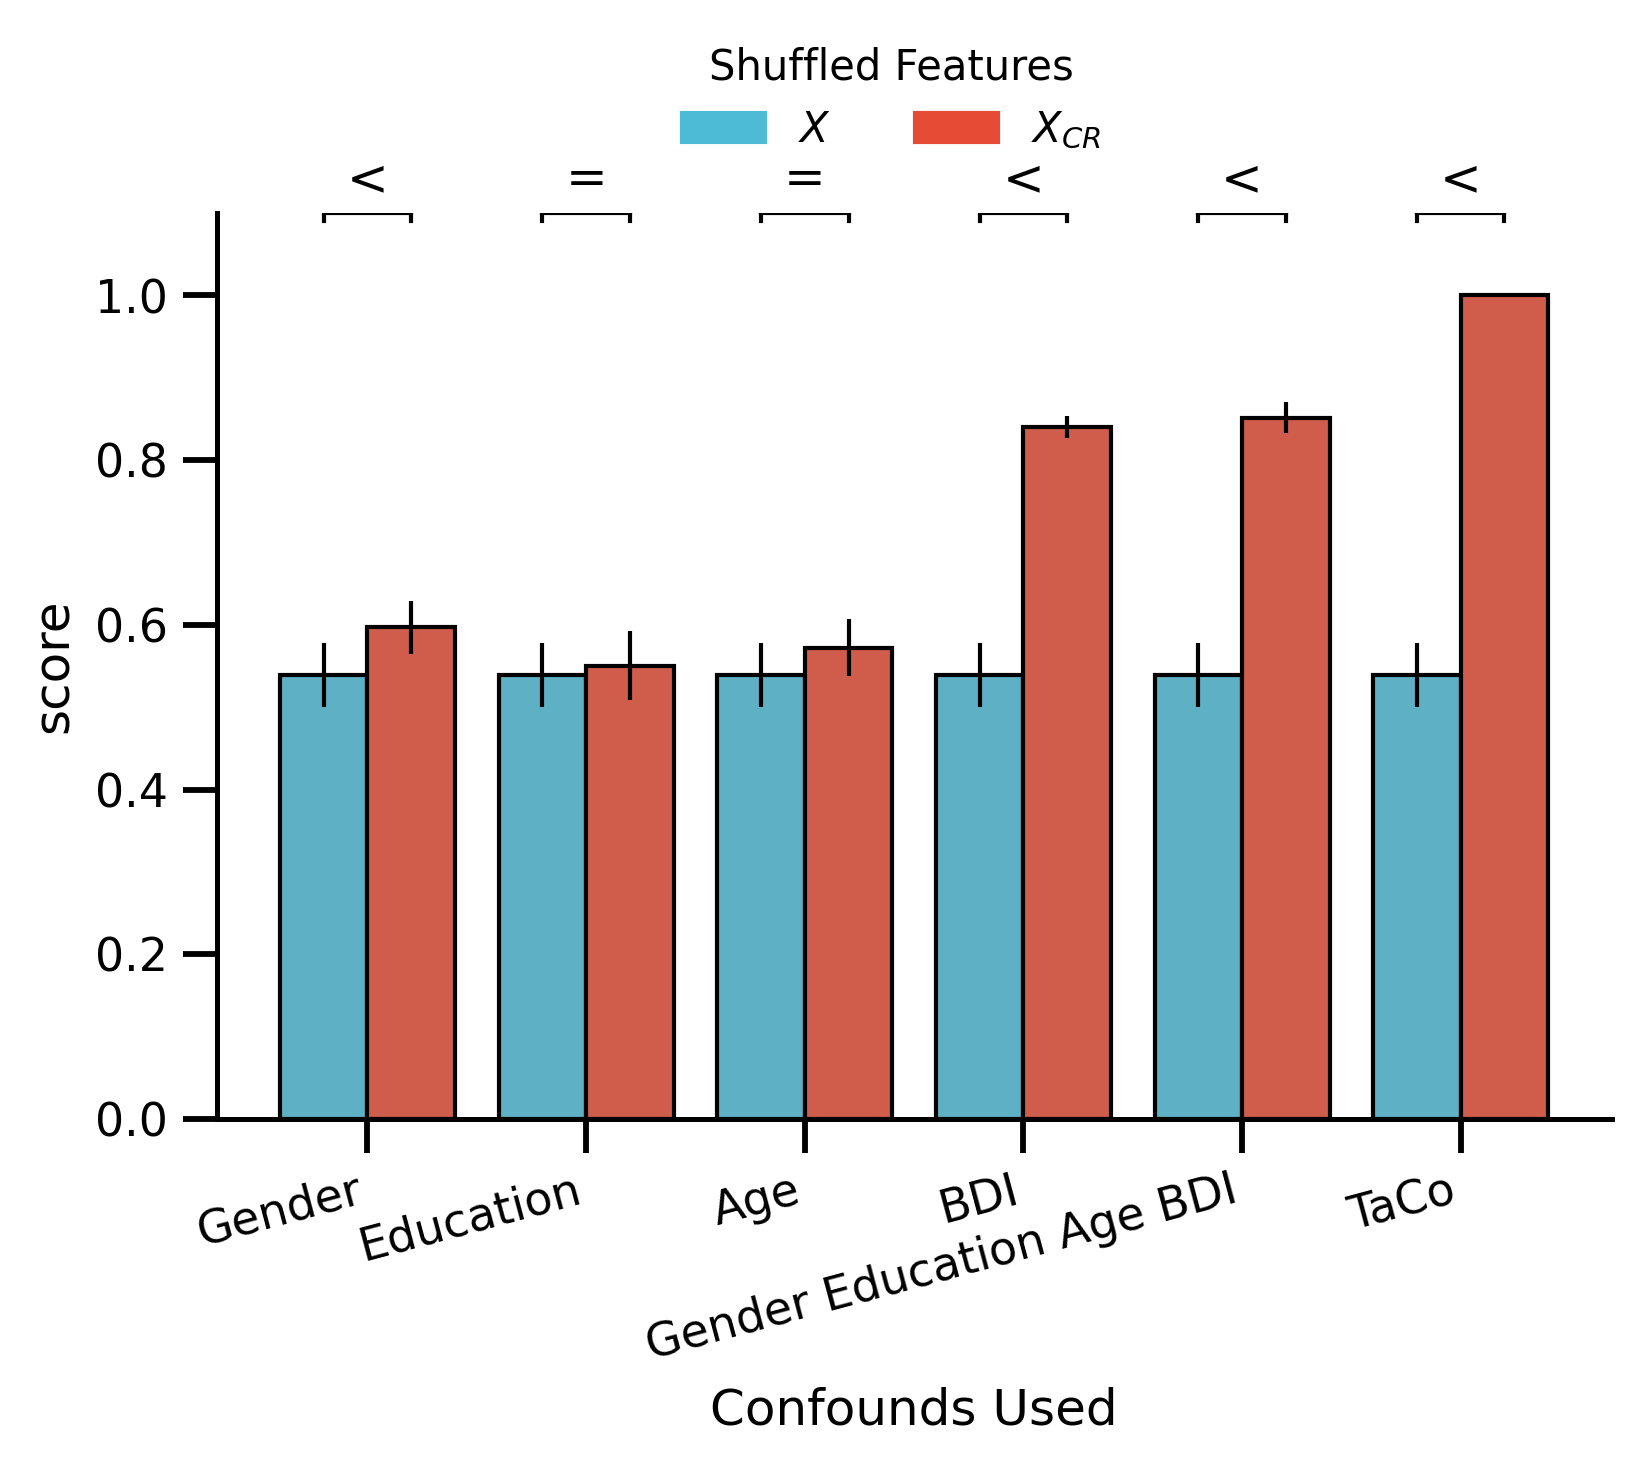

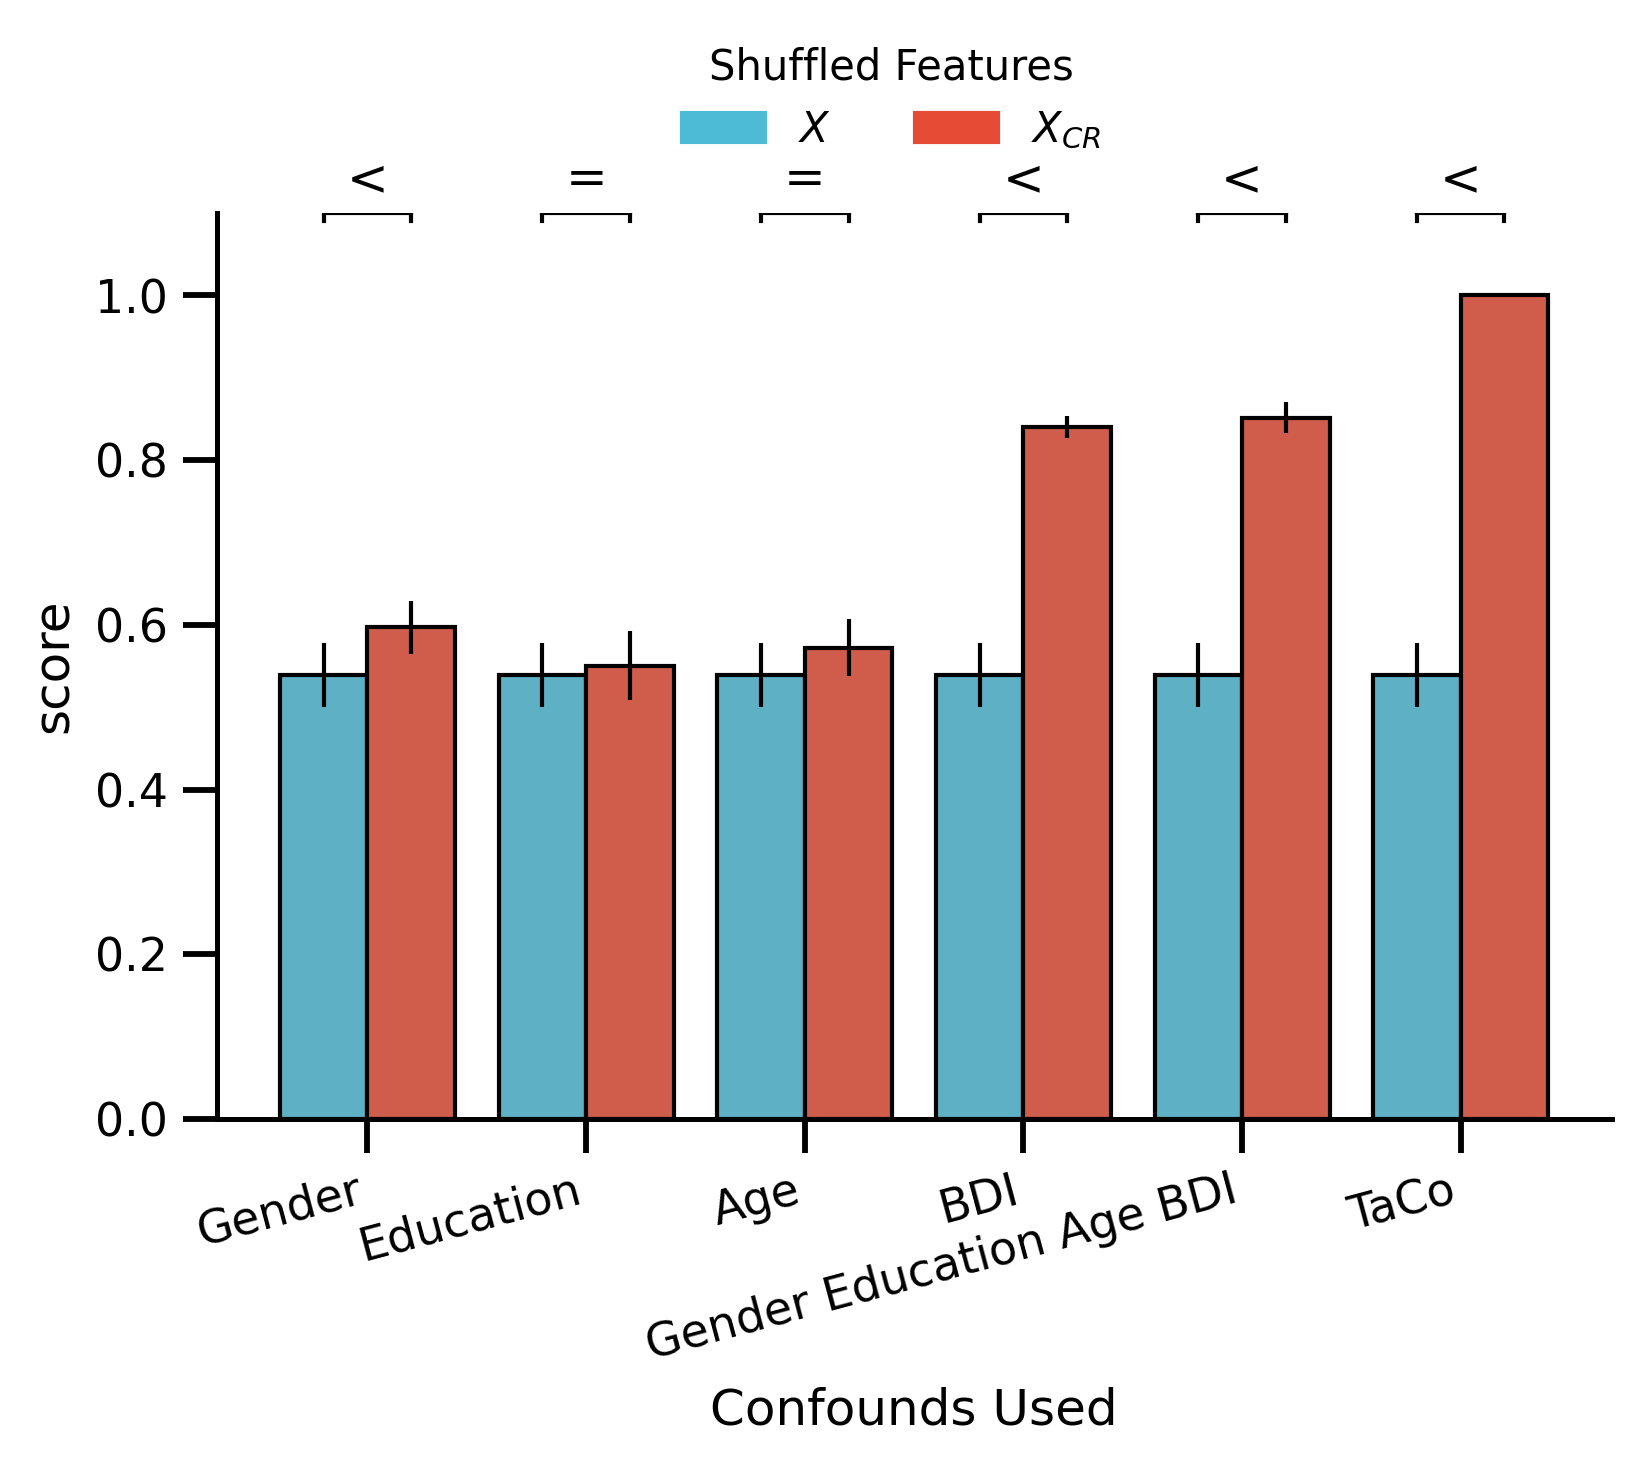

In [9]:
df_bar_plot_shuffled = (
    pd.concat(
        [
            df_long_shuffled_non_TaCo.copy().query("model_name == 'Random Forest'"),
            (
                df_long_shuffled_TaCo.assign(confounds_used="TaCo")
                .query("model_name == 'Random Forest'")
                .query("data == 'audio_data'")
                .reset_index(drop=True)
            ),
        ]
    )
    .dropna()
    .reset_index(drop=True)
)


fig, ax = plt.subplots()
df_bar_plot_shuffled = df_bar_plot_shuffled.query(
    "confound in ['not removed', 'removed']"
)
custom_bar_rope_plot(
    x="confounds_used",
    y="score",
    hue="confound",
    ax=ax,
    hue_order=["not removed", "removed"],
    comparisons=(("not removed", "removed"),),
    comparisons_sing_y=(1.1,),
    cv_repeats="repeat",
    data=df_bar_plot_shuffled,
    rope=0.05,
    order=["Gender", "Education", "Age", "BDI", "Gender_Education_Age_BDI", "TaCo"],
    palette=sns.color_palette([blue, red]),
    show_legend=False,
)
ax.set_xticklabels(
    [i.get_text().replace("_", " ") for i in ax.get_xticklabels()],
    rotation=15,
    ha="right",
)
ax.set_ylim(0, 1.1)
ax.set_xlabel("Confounds Used")

fig.legend(
    handles=handles,
    title="Shuffled Features",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
)

fig.savefig("./saved_figures/all_shuffled_confounds_audio_performance.svg")
fig.savefig("./saved_figures/all_shuffled_confounds_audio_performance.png")
fig.savefig("./saved_figures/all_shuffled_confounds_audio_performance.pdf")
glue("all_shuffled_confounds_performance", fig)


````{tabbed}  using original data 
```{glue:figure} all_confounds_performance
:figwidth: 900px
```

````

````{tabbed}  using confounds 
```{glue:figure} all_shuffled_confounds_performance
:figwidth: 900px
```
````